# Task 1:
Developing a multi-layer neural network for classification using numpy.
### Features
- Sigmoid and ReLU Layers with forward and backward pass
- Softmax layer with forward and backward pass
- Inverted dropout
- Fully parametrizable neural network class
- Two optimizers (SGD & SGD with momentum)

# external sources used:
- loading in the CIFAR-10 Dataset: https://www.kaggle.com/code/farzadnekouei/cifar-10-image-classification-with-cnn/notebook  details on how to load the dataset and be able to see the set of images.
- (No code was taken) Deep Neural net with forward and back propagation: https://www.geeksforgeeks.org/deep-neural-net-with-forward-and-back-propagation-from-scratch-python/  Used to understand what forward and backward propagation is and basics of a NN.


In [2]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


## Importing libraries
We will be using the CIFAR-10 dataset from Keras.

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
# Setting a fixed seed for reproducibility
SEED = 17
np.random.seed(SEED)

In [5]:
# Fetches CIFAR-10 data and splits into train/test sets
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Divides training data for training and validation (10% for validation)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED)

# Flattens images, reshaping all datasets into 1D arrays for processing
X_train_flat = X_train.reshape(X_train.shape[0], -1).astype(np.float32) / 255.0  # Flatten and normalize
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1).astype(np.float32) / 255.0
X_test_flat = X_test.reshape(X_test.shape[0], -1).astype(np.float32) / 255.0

# Print dimensions
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


The data has been correctly split from 50,000 32x32 images to 45,000 training images and 5,000 validation images. 10,000 images for testing have also been correctly imported.

## Visualising the dataset

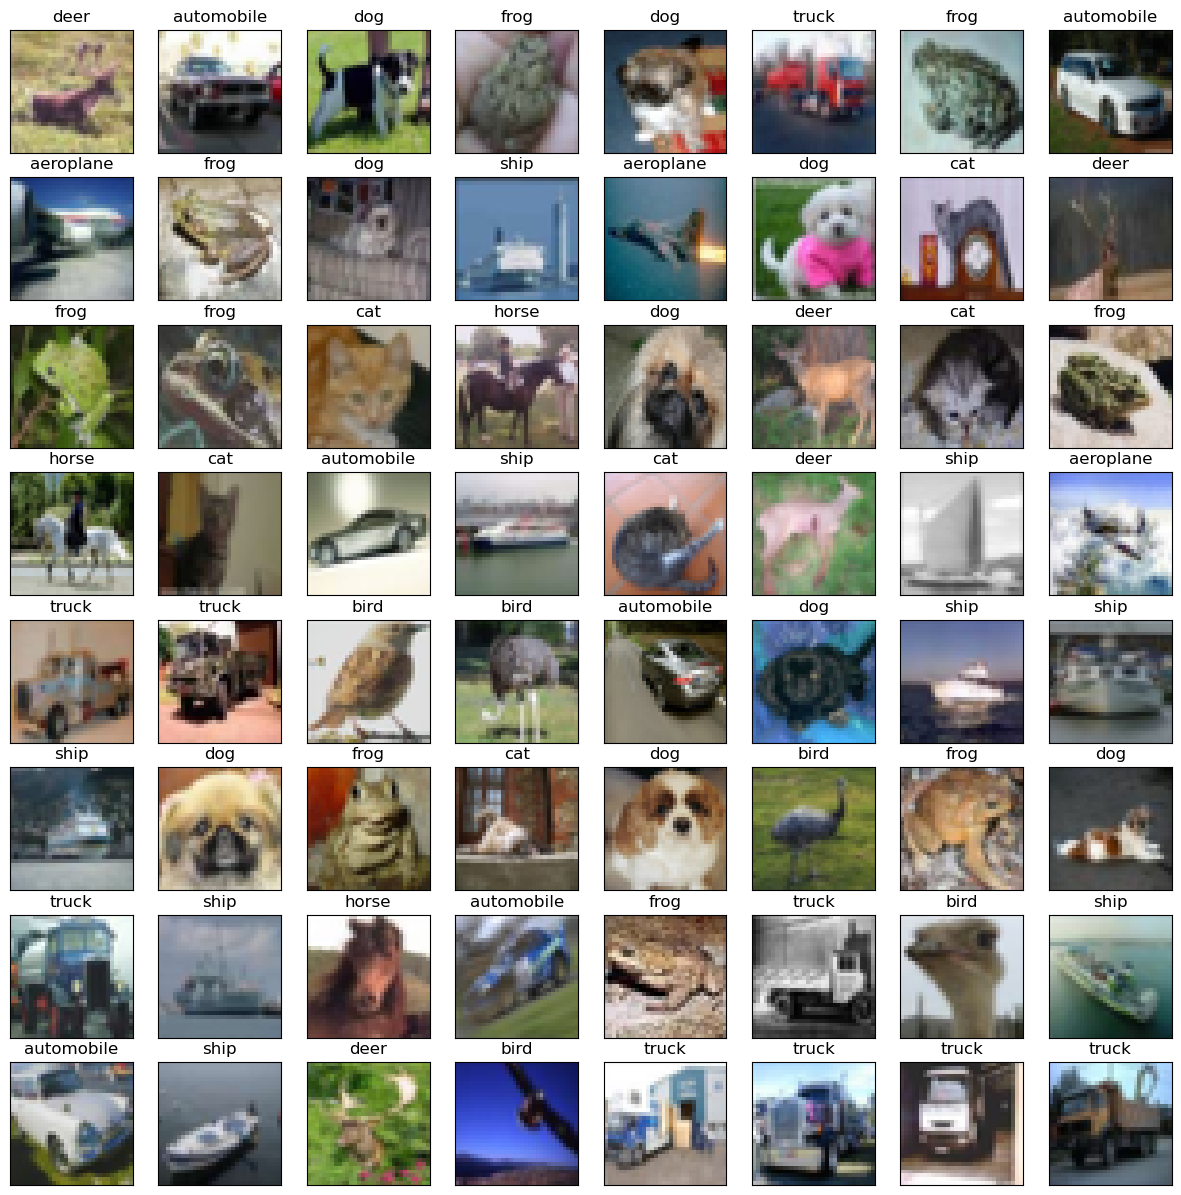

In [6]:
# CIFAR-10 classes
class_names = ["aeroplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Create a new figure
plt.figure(figsize=(15, 15))

# Loop over the first 64 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Reshape the flattened image back to (32, 32, 3) if necessary
    img = X_train[i].reshape(32, 32, 3) if X_train[i].shape == (3072,) else X_train[i]
    
    # Display the image
    plt.imshow(img)

    # Set the label as the title
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

We built a fully connected neural network with customizable layers to evaluate its performance on CIFAR-10 for 10-class classification. The network includes ReLU, Sigmoid, and Softmax activations, dropout for regularization, and is trained using gradient descent with a learning rate of 0.01. The model architecture consists of 10 input nodes, two hidden layers with 16 and 8 nodes, and 10 output nodes. Training was performed over 20 epochs with a batch size of 32, and both training and validation loss were tracked.

In [7]:
class neuralNetwork:
    def __init__(self, layers, activations, dropout_rate=None, regularizer=None, reg_lambda=0.01, learning_rate=0.01):
        self.layers = layers
        self.activations = activations
        self.dropout_rate = dropout_rate if dropout_rate else [1.0] * (len(layers) - 1)
        self.regularizer = regularizer
        self.reg_lambda = reg_lambda
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.weights = [np.random.randn(layers[i], layers[i + 1]) * np.sqrt(2.0 / layers[i]) for i in range(len(layers) - 1)]
        self.biases = [np.zeros((1, layers[i + 1])) for i in range(len(layers) - 1)]

    def activation_forward(self, x, activation):
        if activation == 'relu':
            return np.maximum(0, x)
        elif activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif activation == 'softmax':
            exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
            return exp_x / np.sum(exp_x, axis=1, keepdims=True)
        else:
            raise ValueError(f"Unsupported activation: {activation}")

    def activation_backward(self, da, z, activation):
        if activation == 'relu':
            return da * (z > 0).astype(float)
        elif activation == 'sigmoid':
            sig = 1 / (1 + np.exp(-z))
            return da * sig * (1 - sig)
        elif activation == 'softmax':
            return da
        else:
            raise ValueError(f"Unsupported activation for backward pass: {activation}")

    def apply_dropout(self, a, prob):
        if prob < 1.0:
            mask = (np.random.rand(*a.shape) < prob) / prob
            return a * mask
        return a

    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        if self.regularizer == 'l2':
            loss += (self.reg_lambda / (2 * m)) * sum(np.sum(np.square(w)) for w in self.weights)
        elif self.regularizer == 'l1':
            loss += (self.reg_lambda / m) * sum(np.sum(np.abs(w)) for w in self.weights)
        return loss

    def compute_accuracy(self, y_pred, y_true):
        predictions = np.argmax(y_pred, axis=1)
        labels = np.argmax(y_true, axis=1)
        accuracy = np.mean(predictions == labels)
        return accuracy

    def forward(self, X):
        self.caches = {'A0': X}
        A = X

        for i in range(len(self.weights)):
            Z = np.dot(A, self.weights[i]) + self.biases[i]
            A = self.activation_forward(Z, self.activations[i])
            if self.dropout_rate[i] < 1.0 and i < len(self.weights) - 1:
                A = self.apply_dropout(A, self.dropout_rate[i])
            self.caches[f'Z{i+1}'] = Z
            self.caches[f'A{i+1}'] = A

        return A

    def backward(self, X, Y):
        m = Y.shape[0]
        grads = {'dW': [], 'db': []}
        A_L = self.caches[f'A{len(self.weights)}']

        dZ = A_L - Y

        for i in reversed(range(len(self.weights))):
            A_prev = self.caches[f'A{i}']
            grads['dW'].insert(0, np.dot(A_prev.T, dZ) / m)
            grads['db'].insert(0, np.sum(dZ, axis=0, keepdims=True) / m)

            if self.regularizer == 'l2':
                grads['dW'][0] += (self.reg_lambda / m) * self.weights[i]
            elif self.regularizer == 'l1':
                grads['dW'][0] += (self.reg_lambda / m) * np.sign(self.weights[i])

            if i > 0:
                dA = np.dot(dZ, self.weights[i].T)
                dZ = self.activation_backward(dA, self.caches[f'Z{i}'], self.activations[i-1])

        return grads

    def update_params(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads['dW'][i]
            self.biases[i] -= self.learning_rate * grads['db'][i]

    def train(self, X_train, Y_train, epochs, batch_size):
        train_loss = []
        train_accuracy = []
        m = X_train.shape[0]

        for epoch in range(epochs):
            epoch_loss = 0
            epoch_acc = 0
            indices = np.random.permutation(m)
            X_train, Y_train = X_train[indices], Y_train[indices]

            for i in range(0, m, batch_size):
                X_batch = X_train[i:i + batch_size]
                Y_batch = Y_train[i:i + batch_size]

                Y_pred = self.forward(X_batch)
                loss = self.compute_loss(Y_pred, Y_batch)
                accuracy = self.compute_accuracy(Y_pred, Y_batch)

                epoch_loss += loss
                epoch_acc += accuracy

                grads = self.backward(X_batch, Y_batch)
                self.update_params(grads)

            train_loss.append(epoch_loss / ((m + batch_size - 1) // batch_size))
            train_accuracy.append(epoch_acc / ((m + batch_size - 1) // batch_size))

            print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss[-1]:.4f}, Accuracy: {train_accuracy[-1]:.4f}")

        return train_loss, train_accuracy

    def plot_loss(self, train_loss):
        plt.figure(figsize=(8, 5))
        plt.plot(train_loss, label="Training Loss")
        plt.title("Loss Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_accuracy(self, train_accuracy):
        plt.figure(figsize=(8, 5))
        plt.plot(train_accuracy, label="Training Accuracy")
        plt.title("Accuracy Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

# Ensure data is flattened and normalized
input_size = 32 * 32 * 3 
output_size = 10
epochs = 100
learning_rate = 0.1

# One-hot encode labels
y_train = np.eye(10)[y_train.flatten().astype(int)]
y_valid = np.eye(10)[y_valid.flatten().astype(int)]
y_test = np.eye(10)[y_test.flatten().astype(int)]

# Training with neuralNetwork class
nn = neuralNetwork(
    layers=[input_size, 128, output_size],
    activations=['relu', 'softmax'],
    learning_rate=learning_rate
)

train_loss, train_accuracy = nn.train(
    X_train=X_train_flat, Y_train=y_train, epochs=epochs, batch_size=64
)

Epoch 1/100, Loss: 2.0456, Accuracy: 0.2475
Epoch 2/100, Loss: 1.8639, Accuracy: 0.3212
Epoch 3/100, Loss: 1.8007, Accuracy: 0.3462
Epoch 4/100, Loss: 1.7492, Accuracy: 0.3678
Epoch 5/100, Loss: 1.7229, Accuracy: 0.3792
Epoch 6/100, Loss: 1.6924, Accuracy: 0.3951
Epoch 7/100, Loss: 1.6625, Accuracy: 0.4062
Epoch 8/100, Loss: 1.6421, Accuracy: 0.4139
Epoch 9/100, Loss: 1.6265, Accuracy: 0.4174
Epoch 10/100, Loss: 1.6189, Accuracy: 0.4209
Epoch 11/100, Loss: 1.6037, Accuracy: 0.4300
Epoch 12/100, Loss: 1.5948, Accuracy: 0.4310
Epoch 13/100, Loss: 1.5752, Accuracy: 0.4376
Epoch 14/100, Loss: 1.5652, Accuracy: 0.4415
Epoch 15/100, Loss: 1.5565, Accuracy: 0.4433
Epoch 16/100, Loss: 1.5451, Accuracy: 0.4502
Epoch 17/100, Loss: 1.5304, Accuracy: 0.4555
Epoch 18/100, Loss: 1.5230, Accuracy: 0.4568
Epoch 19/100, Loss: 1.5123, Accuracy: 0.4617
Epoch 20/100, Loss: 1.4973, Accuracy: 0.4672
Epoch 21/100, Loss: 1.4899, Accuracy: 0.4700
Epoch 22/100, Loss: 1.4865, Accuracy: 0.4715
Epoch 23/100, Loss:

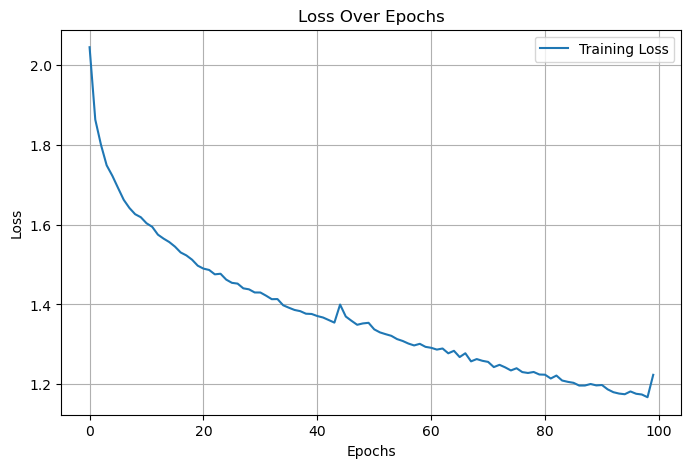

In [8]:
nn.plot_loss(train_loss)

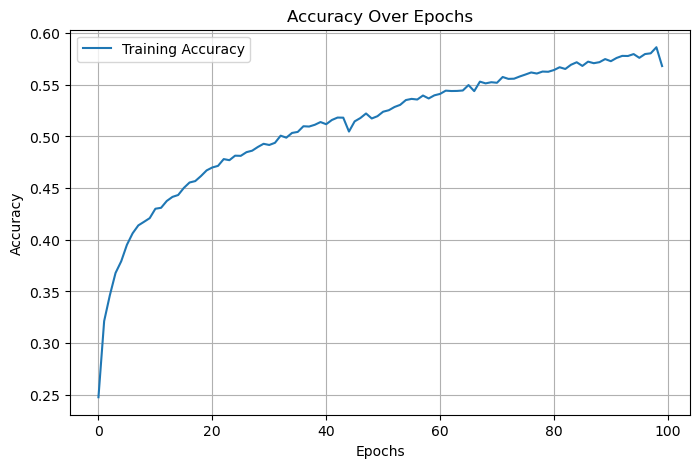

In [9]:
nn.plot_accuracy(train_accuracy)

we have built the softmax function so it calculates probabilities for each class by exponentiating the input values, normalizing them for stability. The cross_entropy_loss measures how well the predicted probabilities match the true labels, with safeguards to avoid math errors. Weights and biases are initialized with scaled random values (for weights) and zeros (for biases). During the softmax_forward_backward function, the forward pass computes the class probabilities and loss, while the backward pass calculates gradients for weights and biases. These are then updated using gradient descent to optimize the model.

In [10]:
# Softmax function
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability 
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Cross-Entropy Loss
def cross_entropy_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)  # Avoid log(0)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

# Initialize weights and biases
def initialize_weights(input_size, output_size):
    weights = np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size)  # He initialization
    biases = np.zeros((1, output_size))
    return weights, biases
    

# Derivative of softmax with cross-entropy
def softmax_cross_entropy_backward(y_true, y_pred):
    return (y_pred - y_true) / y_true.shape[0]

# Forward and Backward Pass for Softmax
def softmax_forward_backward(x, y, weights, biases, learning_rate=0.01):
    # Forward pass
    z = np.dot(x, weights) + biases
    a = softmax(z)

    # Cross-entropy loss
    loss = cross_entropy_loss(y_train_one_hot, a)

    # Backward pass
    d_a = softmax_cross_entropy_backward(y, a)
    d_weights = np.dot(x.T, d_a)
    d_biases = np.sum(d_a, axis=0, keepdims=True)

    # Update weights and biases
    weights -= learning_rate * d_weights
    biases -= learning_rate * d_biases

    return loss, weights, biases

Next we have implemented training through the use of the sigmoid activation function.
Weights are initialized with random values scaled by the input size, and biases are set to zero. During the forward pass, the model computes a weighted sum of inputs, applies softmax for probabilities, and calculates cross-entropy loss. The backward pass computes gradients for weights and biases, which are updated using gradient descent.

The train function processes the data in mini-batches, performing forward and backward passes for each batch. The loss is averaged per epoch and tracked. Images are preprocessed by flattening and normalizing pixel values, while labels are one-hot encoded.

Finally, the model is trained, and the loss over epochs is plotted to show learning progress.


Epoch 1/10, Loss: 0.3710
Epoch 2/10, Loss: 0.3428
Epoch 3/10, Loss: 0.3401
Epoch 4/10, Loss: 0.3387
Epoch 5/10, Loss: 0.3377
Epoch 6/10, Loss: 0.3370
Epoch 7/10, Loss: 0.3363
Epoch 8/10, Loss: 0.3358
Epoch 9/10, Loss: 0.3353
Epoch 10/10, Loss: 0.3349


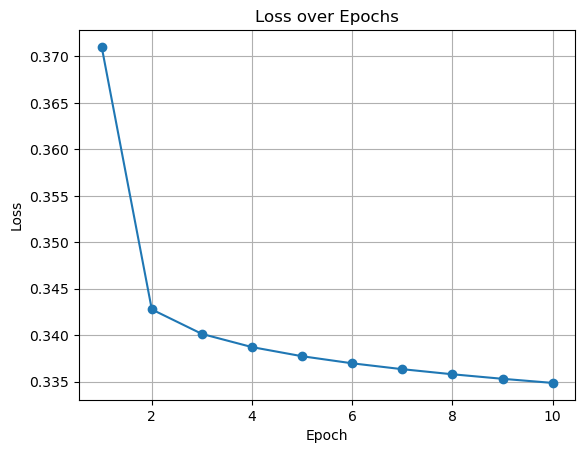

In [11]:
#define the sigmoid activation function
def sigmoid(x):
    s = 1 / 1 + (np.exp(-x))
    return s

#define the derivative of sigmoid
def sigmoid_derivative(x):
    ds = x * (1-x)
    return ds

# Initialize weights and biases
def initialize_weights(input_size, output_size):
    weights = np.random.randn(input_size, output_size).astype(np.float32) * np.sqrt(2.0 / input_size)
    biases = np.zeros((1, output_size), dtype =np.float32)
    return weights, biases

#define forward and backward pass/ propagation for the sigmoid function
def forward_backward_pass(x, y, weights, biases, learning_rate=0.001):
    # Forward pass
    z = np.dot(x, weights) + biases
    a = softmax(z)
    #return loss, weights, biases

    loss = cross_entropy_loss(y,a)
    
    # Backward pass
    d_loss = (a - y).astype(np.float32) / y.shape[0]  # Gradient of loss with respect to predictions
    d_weights = np.dot(x.T, d_loss) / x.shape[0]  # Gradient w.r.t weights
    d_biases = np.sum(d_loss, axis=0, keepdims=True) / x.shape[0]  # Gradient w.r.t biases
    
    # Update weights and biases
    weights -= learning_rate * d_weights
    biases -= learning_rate * d_biases
    
    return loss, weights, biases

# Training
def train(x_train, y_train, input_size, output_size, epochs=10, batch_size = 64, learning_rate=0.01):
    weights, biases = initialize_weights(input_size, output_size)
    losses = [] # initialize the list to track losses over epochs.
    
    num_batches = x_train.shape[0] // batch_size
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(num_batches):
            # Create mini-batches
            start = i * batch_size
            end = start + batch_size
            x_batch = x_train[start:end]
            y_batch = y_train[start:end]

            # Forward and backward pass
            loss, weights, biases = forward_backward_pass(x_batch, y_batch, weights, biases, learning_rate)
            epoch_loss += loss

        # Record and print the average loss for the epoch
        losses.append(epoch_loss / num_batches)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {losses[-1]:.4f}")
    
    return weights, biases, losses

# Set hyperparameters
input_size = 32 * 32 * 3
output_size = 10  # Number of classes
epochs = 10
batch_size = 64
learning_rate = 0.1

# Preprocess data: Flatten and normalize
X_train = X_train.reshape(X_train.shape[0], -1).astype(np.float32) / 255.0  
X_valid = X_valid.reshape(X_valid.shape[0], -1).astype(np.float32) / 255.0  
X_test = X_test.reshape(X_test.shape[0], -1).astype(np.float32) / 255.0    


y_train = np.eye(10)[y_train.flatten().astype(int)]
y_valid = np.eye(10)[y_valid.flatten().astype(int)]
y_test = np.eye(10)[y_test.flatten().astype(int)]

# Train the model
weights, biases, losses = train(X_train, y_train, input_size, output_size, epochs, batch_size, learning_rate)

# Plot the loss graph
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.grid()
plt.show()

Our next task was to define the ReLU activation function. 
ReLU Activation: The function turns any negative input into zero, and leaves positive values unchanged. It's a common way to introduce non-linearity in models.

ReLU Derivative: This tells us how to adjust weights during backpropagation. If the input is positive, the derivative is 1, otherwise it's 0.

Weight and Bias Initialization: The weights are small random values, and biases are set to zero at the start. This helps the model begin training.

Forward and Backward Pass:

In the forward pass, the input data is passed through the model, transformed by the weights and biases, and then activated by ReLU.
The loss is calculated to measure how far the model’s predictions are from the actual values.
In the backward pass, we compute the gradients of the loss with respect to weights and biases, and then update them to reduce the error.
Training Loop: Over several iterations (epochs), the model keeps adjusting the weights and biases to minimize the error, using the forward and backward passes.


In [12]:
#define the ReLU activation function 

def ReLU(x):
    return np.maximum(0, x)

#define the derivation of the ReLU function
def ReLU_derivative(x):
    return (x > 0).astype(float)

# Initialize weights and biases
def initialize_weights(input_size, output_size):
    weights = np.random.randn(input_size, output_size) * 0.01
    biases = np.zeros((1, output_size))
    return weights, biases

# Forward and backward pass with ReLU
def forward_backward_pass_ReLu(x, y, weights, biases, learning_rate=0.01):
    # Forward pass
    z = np.dot(x, weights) + biases  # Linear transformation
    a = ReLU(z)                      # Apply ReLU activation

    # Loss (mean squared error for simplicity)
    loss = -np.mean(np.sum(y * np.log(a + 1e-15), axis=1))

    # Backward pass
    d_loss = 2 * (a - y) / y.size        # Derivative of loss w.r.t. a
    d_a = d_loss * ReLU_derivative(z)   # Backprop through ReLU (using chain rule)
    
    d_weights = np.dot(x.T, d_a)        # Gradient w.r.t. weights
    d_biases = np.sum(d_a, axis=0, keepdims=True)  # Gradient w.r.t. biases

    # Update weights and biases
    weights -= learning_rate * d_weights
    biases -= learning_rate * d_biases

    return loss, weights, biases

# Training
def train_ReLu(X_train, y_train, input_size, output_size, epochs=10, learning_rate=0.01):
    
    # Trains the model using ReLU activation and mean squared error loss.
    
    weights, biases = initialize_weights(input_size, output_size)
    
    for epoch in range(epochs):
        loss, weights, biases = forward_backward_pass_ReLu(X_train, y_train, weights, biases, learning_rate)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")
    
    return weights, biases

Our implementation here compares Stochastic Gradient Descent (SGD) and SGD with Momentum for training a neural network. SGD updates weights directly based on gradients, while Momentum adds a "velocity" term to speed up updates and reduce oscillations, leading to faster convergence. Weights are initialized using Xavier initialization, and biases are set to zero. The data is preprocessed by flattening images, normalizing them, and one-hot encoding the labels. Training is done in mini-batches, using softmax for predictions and cross-entropy loss.


Training with SGD Optimizer:
Epoch 1/20, Loss: 2.3378
Epoch 2/20, Loss: 2.3374
Epoch 3/20, Loss: 2.3371
Epoch 4/20, Loss: 2.3367
Epoch 5/20, Loss: 2.3363
Epoch 6/20, Loss: 2.3360
Epoch 7/20, Loss: 2.3356
Epoch 8/20, Loss: 2.3353
Epoch 9/20, Loss: 2.3349
Epoch 10/20, Loss: 2.3346
Epoch 11/20, Loss: 2.3342
Epoch 12/20, Loss: 2.3338
Epoch 13/20, Loss: 2.3335
Epoch 14/20, Loss: 2.3331
Epoch 15/20, Loss: 2.3328
Epoch 16/20, Loss: 2.3324
Epoch 17/20, Loss: 2.3321
Epoch 18/20, Loss: 2.3317
Epoch 19/20, Loss: 2.3314
Epoch 20/20, Loss: 2.3310

Training with SGD Momentum Optimizer:
Epoch 1/20, Loss: 2.5848
Epoch 2/20, Loss: 2.5868
Epoch 3/20, Loss: 2.5828
Epoch 4/20, Loss: 2.5789
Epoch 5/20, Loss: 2.5751
Epoch 6/20, Loss: 2.5713
Epoch 7/20, Loss: 2.5676
Epoch 8/20, Loss: 2.5639
Epoch 9/20, Loss: 2.5602
Epoch 10/20, Loss: 2.5566
Epoch 11/20, Loss: 2.5530
Epoch 12/20, Loss: 2.5495
Epoch 13/20, Loss: 2.5461
Epoch 14/20, Loss: 2.5427
Epoch 15/20, Loss: 2.5393
Epoch 16/20, Loss: 2.5359
Epoch 17/20, 

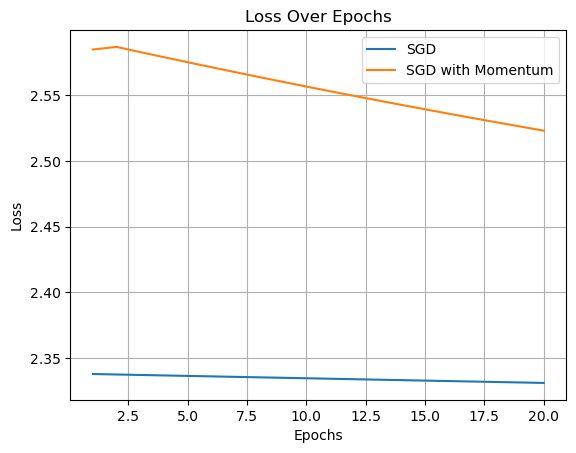

In [13]:
# Implementing the SGD optimizer
def SGDoptimizer(weights, biases, gradients, learning_rate):
    d_weights, d_biases = gradients

    # Update weights and biases using the SGD formula
    weights -= learning_rate * d_weights
    biases -= learning_rate * d_biases

    return weights, biases

# Implementing the SGD with Momentum optimizer
def SGDmomentumOptimizer(weights, biases, gradients, velocities, learning_rate, momentum=0.9):
    d_weights, d_biases = gradients
    v_weights, v_biases = velocities

    # Update velocities based on gradients and momentum
    v_weights = momentum * v_weights - learning_rate * d_weights
    v_biases = momentum * v_biases - learning_rate * d_biases

    # Update weights and biases using the velocities
    weights += v_weights
    biases += v_biases

    return weights, biases, (v_weights, v_biases)

# Initialize weights and biases
def initialize_weights(input_size, output_size):
    weights = np.random.randn(input_size, output_size) * np.sqrt(1.0 / input_size) # Xavier initialization
    biases = np.zeros((1, output_size))
    return weights, biases

# Training with selected optimizer
def train_with_optimizer(
    x_train, y_train, input_size, output_size, epochs=10, learning_rate=0.1,
    optimizer="SGDoptimizer", momentum=0.9, batch_size=64
):
    # Initialize weights and biases
    weights, biases = initialize_weights(input_size, output_size)

    # Initialize velocities for SGD with momentum
    velocities = (np.zeros_like(weights), np.zeros_like(biases))

    # Store losses for each epoch
    epoch_losses = []

    num_batches = x_train.shape[0] // batch_size 

    for epoch in range(epochs):
        epoch_loss = 0 

        for i in range(num_batches):
            # Create mini-batches
            start = i * batch_size
            end = start + batch_size
            x_batch = x_train[start:end]
            y_batch = y_train[start:end]

            # Forward pass using softmax
            z = np.dot(x_batch, weights) + biases
            a = softmax(z)

            # Cross-entropy loss
            loss = -np.mean(np.sum(y_batch * np.log(a + 1e-15), axis=1))
            epoch_loss += loss

            # Backward pass
            d_weights = np.dot(x_batch.T, (a - y_batch))
            d_biases = np.sum(a - y_batch, axis=0, keepdims=True)

            # Update weights and biases using the selected optimizer
            if optimizer == "SGDoptimizer":
                weights, biases = SGDoptimizer(weights, biases, (d_weights, d_biases), learning_rate)
            elif optimizer == "SGDmomentumOptimizer":
                weights, biases, velocities = SGDmomentumOptimizer(
                    weights, biases, (d_weights, d_biases), velocities,
                    learning_rate, momentum
                )
            else:
                raise ValueError(f"Unknown optimizer: {optimizer}")

        # Record and print the average loss for the epoch
        epoch_loss /= num_batches
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

    return weights, biases, epoch_losses


X_train = np.random.rand(45000, 32, 32, 3) 
y_train = np.random.randint(0, 10, size=(45000,))  

# Preprocess data: Flatten and normalize - Ask if necessary with teammates
X_train = X_train.reshape(X_train.shape[0], -1).astype(np.float32) / 255.0 

# One-hot encode labels - Ask if necessary with teammates
y_train = np.eye(10)[y_train.flatten().astype(int)] 

# Set hyperparameters
input_size = 32 * 32 * 3 
output_size = 10
epochs = 20
learning_rate = 0.1
momentum = 0.9

# Training with SGD Optimizer
print("\nTraining with SGD Optimizer:")
_, _, losses_sgd = train_with_optimizer(
    x_train=X_train, y_train=y_train, 
    input_size=input_size, output_size=output_size, 
    epochs=epochs, learning_rate=learning_rate, 
    optimizer="SGDoptimizer", batch_size=64
)

# Training with SGD Momentum Optimizer
print("\nTraining with SGD Momentum Optimizer:")
_, _, losses_momentum = train_with_optimizer(
    x_train=X_train, y_train=y_train, 
    input_size=input_size, output_size=output_size, 
    epochs=epochs, learning_rate=learning_rate, 
    optimizer="SGDmomentumOptimizer", momentum=momentum, batch_size=64
)

# Plot the loss graph
plt.plot(range(1, epochs + 1), losses_sgd, label="SGD")
plt.plot(range(1, epochs + 1), losses_momentum, label="SGD with Momentum")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()